In [1]:
import os
import subprocess

import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, CenterCrop, Resize
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet101
from torch.utils.data import DataLoader
from torch.optim import Adam

from nuy_v2_loader import NYUV2Dataset
from stepper import Stepper

In [2]:
# CONSTANTS
SEED = 43
EPSILON = 1e-6

In [3]:
np.random.seed(SEED)

In [4]:
# if not os.path.exists('datasets/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [5]:
NYU_V2_IMG_DIMENSION = (448, 608)

transforms = Compose([
  ToTensor(), CenterCrop(NYU_V2_IMG_DIMENSION), Resize(size=(224, 304))
])
train_dataset = NYUV2Dataset("ds", transforms, transforms, 'train', download=True)
test_dataset = NYUV2Dataset("ds", transforms, transforms, 'test', download=True)

Failed to load tar file
Finished loading dataset
Failed to load tar file
Finished loading dataset


/home/jovyan/workspace/pure_depth/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


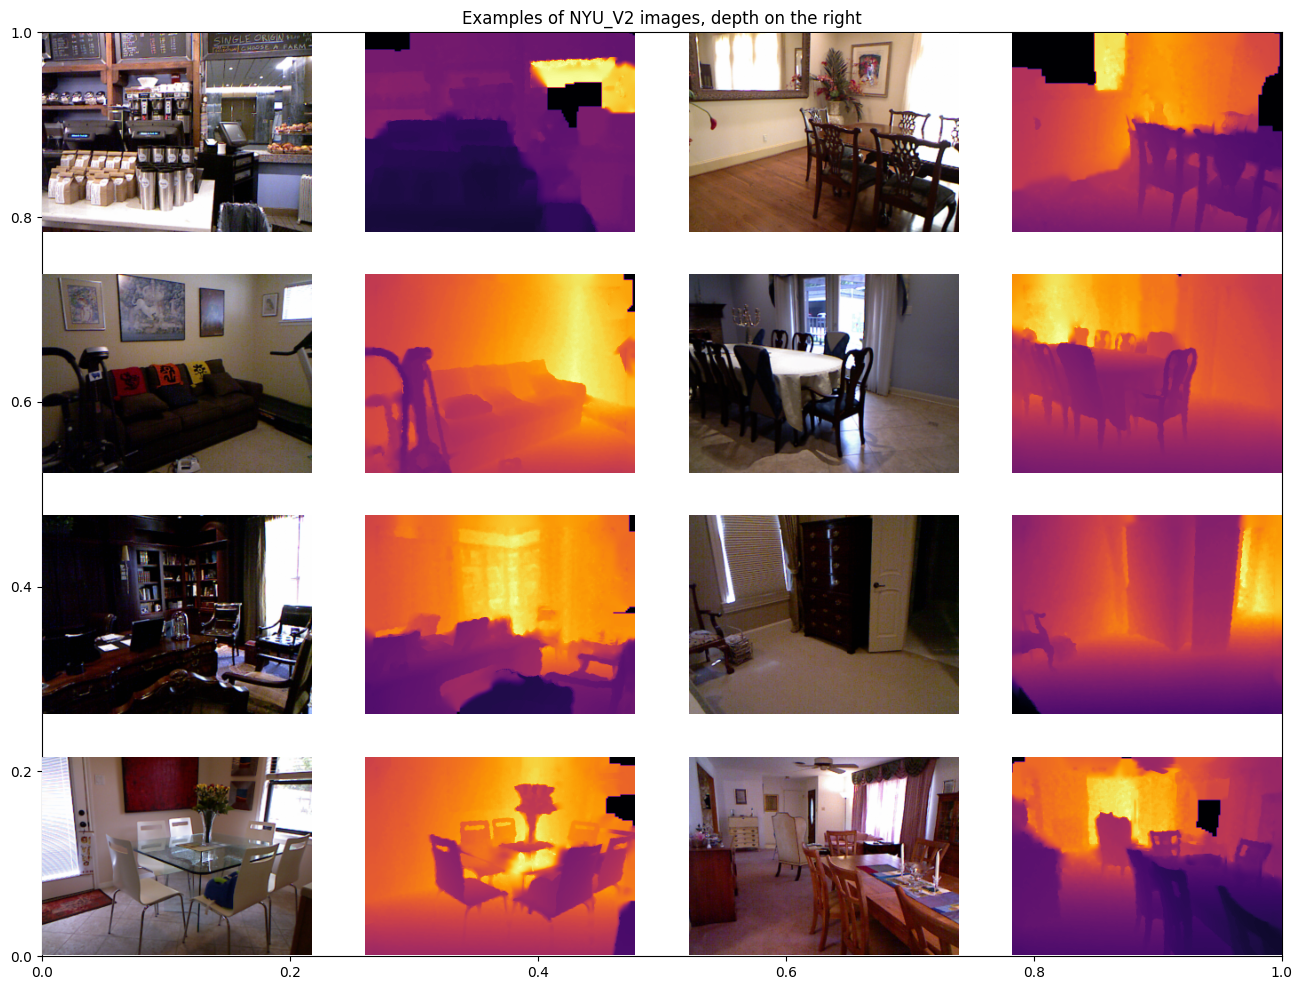

In [6]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [7]:
class Baseline(nn.Module):
  def __init__(self, pretrained_encoder=True):
    super().__init__()
    weights = torchvision.models.ResNet101_Weights.IMAGENET1K_V2 if pretrained_encoder else None
    encoder = resnet101(weights=weights, progress=True)
    for p in encoder.parameters():
      p.requires_grad_(False)
    
    self.layer0 = nn.Sequential(encoder.conv1, encoder.bn1, encoder.relu, encoder.maxpool)
    self.layer1 = nn.Sequential(encoder.layer1) # CxHxW ~> 256x1/4Hx1/4W
    self.layer2 = nn.Sequential(encoder.layer2) # CxHxW ~> 512x1/8Hx1/8W
    self.layer3 = nn.Sequential(encoder.layer3) # CxHxW ~> 1024x1/16Hx1/16W
    self.layer4 = nn.Sequential(encoder.layer4) # CxHxW ~> 2048x1/32Hx1/32W
    
    self.dec0 = nn.Conv2d(2048, 256, kernel_size=1)
    self.dec1 = nn.Conv2d(1024, 256, kernel_size=1)
    self.dec2 = nn.Conv2d(512, 256, kernel_size=1)
    self.dec3 = nn.Conv2d(256, 256, kernel_size=1)
    
    self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    
    self.predictor0 = self._smooth(256, 64)
    self.predictor1 = self._smooth(64, 1)
    
  def _smooth(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )
    
  def _upsample(self, x, y):
    _,_,H,W = y.size()
    return F.upsample(x, size=(H, W), mode='bilinear') + y
    
  def forward(self, x):
    _,_,H,W = x.size()
    # Top -> Down
    e0 = self.layer0(x)
    e1 = self.layer1(e0)
    e2 = self.layer2(e1)
    e3 = self.layer3(e2)
    e4 = self.layer4(e3)
    
    # Down -> Top
    d0 = self.dec0(e4) # # CxHxW ~> 256Cx1/32Hx1/32W
    d1 = self._upsample(d0, self.dec1(e3)) # 256Cx1/16Hx1/16W
    d1 = self.smooth1(d1)
    
    d2 = self._upsample(d1, self.dec2(e2)) # 256Cx1/8Hx1/8W
    d2 = self.smooth2(d2)
    
    d3 = self._upsample(d2, self.dec3(e1)) # 256Cx1/4Hx1/4W
    d3 = self.smooth3(d3)
    
    p = self.predictor0(d3) # 64Cx1/4Hx1/4W
    p1 = self.predictor1(p)
    return F.upsample(p1, size=(H, W), mode='bicubic')  # 1Cx1/4Hx1/4W
    

In [8]:
def sil_loss(y_hat, y_true):
  mask = (y_hat > 0) & (y_true > 0)
  
  diff = torch.log(y_hat[mask] + EPSILON) - torch.log(y_true[mask] + EPSILON)
  loss = (diff ** 2).mean() - diff.mean() ** 2
  
  return loss

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
base_model = Baseline()
optim = Adam(base_model.parameters())
stepper = Stepper(base_model, optim=optim, loss_fn=sil_loss)
stepper.set_loaders(train_loader, val_loader)
stepper.to(device)

In [10]:
stepper.train(n_epochs=1)

train step:   0%|          | 0/1487 [00:00<?, ?batch/s]/home/jovyan/workspace/pure_depth/env/lib/python3.9/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
train step:   0%|          | 4/1487 [01:50<11:22:32, 27.61s/batch, loss=0.271]


KeyboardInterrupt: 